In [74]:
import os, time
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

tf.compat.v1.disable_eager_execution()
input_path = 'barbara.jpg'

 
input_image = np.array(Image.open(input_path))


In [68]:
def reflect_pad(tf_input_image, kernel_size, stride):

    input_size = int(tf_input_image.get_shape()[1])
    output_size = int(np.ceil(input_size / stride))

    pad_size = int(np.ceil(((output_size - 1) * stride + kernel_size - input_size) * 0.5))
    
    tf_input_image = tf.pad(tf_input_image, 
                            [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], 
                            "REFLECT")
    
    return tf_input_image


def get_binary_text_mask(for_image, sz=20, position=(128, 128), text='hello world'):

    font_fname = 'FreeSansBold.ttf'
    font_size = sz
    font = ImageFont.truetype(font_fname, font_size)
    img_mask = Image.fromarray(np.array(for_image)*0+255)
    draw = ImageDraw.Draw(img_mask)
    draw.text(position, text, font=font, fill='rgb(0, 0, 0)')

    binary_mask_temp = np.array(img_mask)
    binary_mask = np.zeros_like(binary_mask_temp, dtype=np.float32)
    binary_mask += 1.0
    binary_mask[binary_mask_temp<254] -= 1.0

    return binary_mask

In [69]:
def conv(tf_input_image, n_d=128, k_d=7):

    tf_input_image = reflect_pad(tf_input_image, kernel_size=k_d, stride=2)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=2, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    tf_input_image = reflect_pad(tf_input_image, kernel_size=k_d, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)
    
    return tf_input_image


def transpose_conv(tf_input_image, n_u=128, k_u=7):

    height, width = tf_input_image.get_shape()[1:3]
    tf_input_image = tf.image.resize_images(tf_input_image, [height*2, width*2], 
                                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    tf_input_image = reflect_pad(tf_input_image, kernel_size=k_u, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=k_u, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    # kernel_size=1
    tf_input_image = reflect_pad(tf_input_image, kernel_size=1, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=1, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    return tf_input_image
def skip_connection(tf_input_image, n_s=0, k_s=0):

    tf_input_image = reflect_pad(tf_input_image, kernel_size=k_s, stride=1)
    tf_input_image_sc = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_s, 
                                                 kernel_size=k_s, stride=1, 
                                                 padding='VALID', activation_fn=None)
    tf_input_image_sc = tf.contrib.layers.batch_norm(inputs=tf_input_image_sc, 
                                                     activation_fn=tf.nn.leaky_relu)

    
    tf_input_image = tf.concat([tf_input_image, tf_input_image_sc], axis=3)

    return tf_input_image



def output(tf_input_image, n_o=3, k_o=1):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_o, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_o, 
                                              kernel_size=k_o, stride=1, 
                                              padding='VALID', activation_fn=None)
    return tf_input_image


def image_save(path, img, reshape_size=[512, 512, 3]):
    img = np.array(img)
    img = img.reshape(reshape_size)
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(path, quality=95)


In [76]:
def run(input_image, num_iter, save_every_iter, show_every_iter):

    LR = 0.01
    n_u_list = n_d_list = [16, 32, 64, 128, 128]
    k_u_list = k_d_list = [7, 7, 7, 7, 7]
    n_s_list = [0, 0, 0, 0, 4]
    k_s_list = [0, 0, 0, 0, 1] 
    image_normalize_TF = True
    
    image_shape = [shape for shape in input_image.shape[:-1]]
    output_image_shape = [1] + image_shape + [32]

    binary_mask_1 = get_binary_text_mask(input_image, sz=30, position=(128, 128), 
                                         text='Inpainting')
    binary_mask_2 = get_binary_text_mask(input_image, sz=25, position=(250, 300), 
                                         text='Noct068')
    binary_mask = np.multiply(binary_mask_1, binary_mask_2)

    corrupted_image = np.multiply(input_image, binary_mask)
    corrupted_image = corrupted_image.astype(np.uint8)

    
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('original_image')
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('binary_mask')
    ax2.imshow(binary_mask)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('corrupted_image')
    ax3.imshow(corrupted_image)
    plt.show()
    


    
    input_image_shape = [1] + image_shape + [3]
    input_image = corrupted_image
    if image_normalize_TF:
        input_image = input_image / 255
    input_image = np.reshape(input_image, input_image_shape)    
    input_image = tf.constant(input_image, dtype=tf.float32)
    
    output_image_point = tf.placeholder(shape=output_image_shape, dtype=tf.float32)
    tf_binary_mask = tf.placeholder(shape=input_image_shape[1:], dtype=tf.float32) 

    output_image = output_image_point
    
    for i in range(len(n_d_list)):
        output_image = conv(tf_input_image=output_image, 
                                          n_d=n_d_list[i], k_d=k_d_list[i])
        

    
    output_image = skip_connection(output_image, n_s=n_s_list[-1], k_s=k_s_list[-1])
    
    for i in reversed(range(len(n_u_list))):
        output_image = transpose_conv(tf_input_image=output_image, 
                                        n_u=n_u_list[i], k_u=k_u_list[i])
       

    output_image = output(tf_input_image=output_image, n_o=3, k_o=1)
    

    
    output_image = tf.sigmoid(output_image)

    
    tf_binary_mask_ = tf.expand_dims(tf_binary_mask, 0)
    loss_E = tf.reduce_mean(tf.square(tf.multiply(tf.subtract(output_image, input_image), 
                                                  tf_binary_mask_)))
    optimizer = tf.train.AdamOptimizer(learning_rate=LR)
    train_op = optimizer.minimize(loss_E)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        
        training_start_time = time.time()
        iter_start_time = time.time()
        z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape) 

        for i in range(num_iter+1):
            
            using_dict = {output_image_point: z, tf_binary_mask: binary_mask}

            
            sess.run(train_op, feed_dict=using_dict)

            if i % save_every_iter == 0:
                generate_image, training_loss = sess.run([output_image, loss_E], 
                                                         feed_dict=using_dict)
                generate_image = generate_image[0]

                if image_normalize_TF:
                    generate_image = generate_image * 255
                generate_image = np.clip(generate_image, 0, 255).astype(np.uint8)

                
            
                
                iter_start_time = time.time()

            if i % show_every_iter == 0:
                fig = plt.figure(figsize=(8, 8))
                ax1 = fig.add_subplot(1,2,1)
                ax1.set_title('input_image')
                ax1.imshow(corrupted_image)
                ax2 = fig.add_subplot(1,2,2)
                ax2.set_title('generate_image')
                ax2.imshow(generate_image)
                plt.show()


        plt.imshow(generate_image)
        plt.show()

        return generate_image

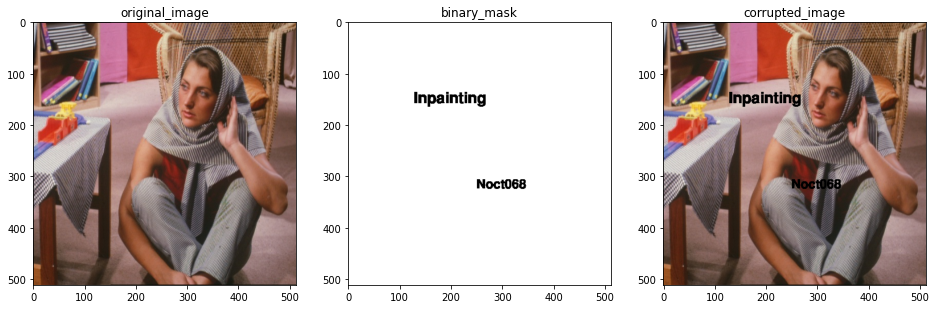

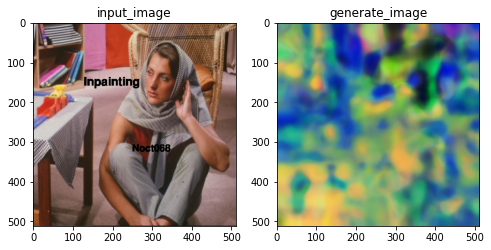

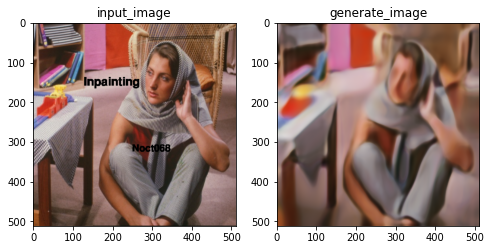

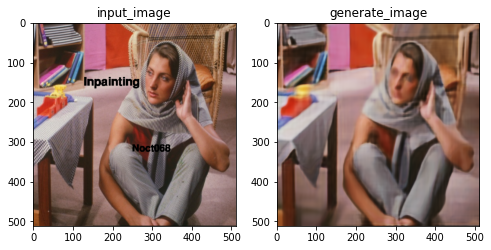

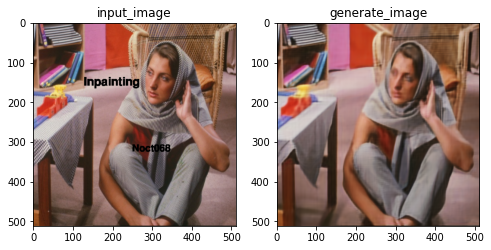

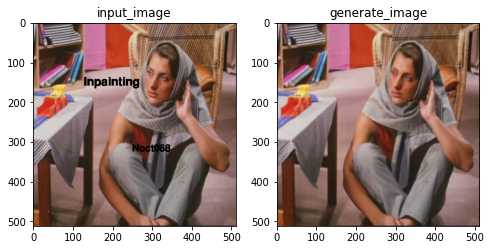

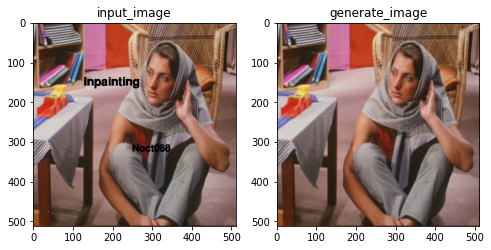

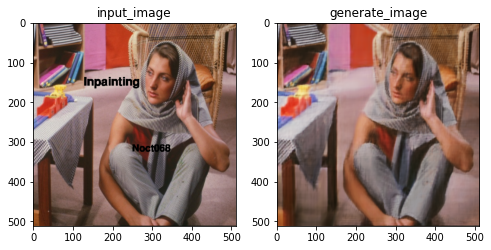

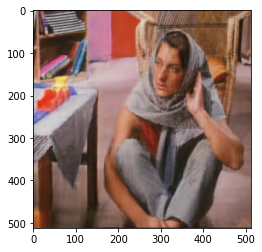

In [77]:
final_image = run(input_image, num_iter, save_every_iter, show_every_iter)